In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
from tqdm import tqdm
from scipy.fft import fft
from scipy.signal.windows import flattop

In [2]:
cic_lib = ctypes.CDLL('./pipe_cic_4d_128.so')
cic_lib.pipe_cic_4d_128.argtypes = [ctypes.c_uint64]
cic_lib.pipe_cic_4d_128.restype = ctypes.POINTER(ctypes.c_int64)

# fir_lib = ctypes.CDLL('./cic4d128comp.so')
# fir_lib.firCIC4D128Comp64.argtypes = [ctypes.c_int64, ctypes.c_int64]
# fir_lib.firCIC4D128Comp64.restype = ctypes.POINTER(ctypes.c_int64)

# decimator_lib = ctypes.CDLL('./decimator2.so')
# decimator_lib.decimator2.argtypes = [ctypes.c_int64, ctypes.c_int64]
# decimator_lib.decimator2.restype = ctypes.POINTER(ctypes.c_int64)

# lpf_lib = ctypes.CDLL('./lpf_03125_05.so')
# lpf_lib.lpf_03125_05.argtypes = [ctypes.c_int64, ctypes.c_int64]
# lpf_lib.lpf_03125_05.restype = ctypes.POINTER(ctypes.c_int64)


  0%|          | 0/8192 [00:00<?, ?it/s]

100%|██████████| 8192/8192 [04:52<00:00, 28.04it/s]


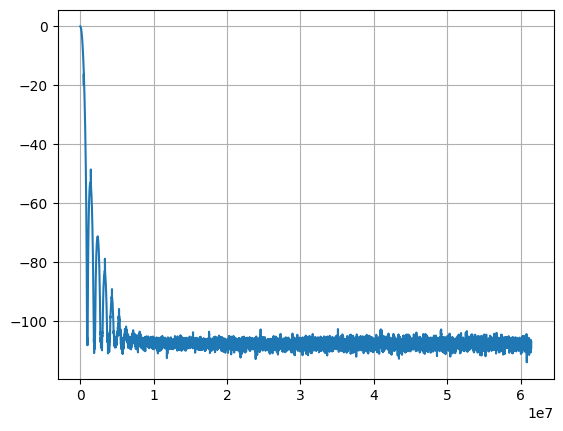

In [3]:
fs = 122.88e6 # Sampling frequency
ts = 1/fs   # Sampling period

freqs_to_scan = np.arange(100, fs/2, ((fs/2)/8192)) + 17

attenuation_dbs = []

for freq in tqdm(freqs_to_scan):
    
    # sample 1.5 periods of the signal
    signal_length = int(2 * (1/freq) * fs) 
    signal_length = signal_length if signal_length > 65536 else 65536

    cic = cic_lib.pipe_cic_4d_128
    # fir = fir_lib.firCIC4D128Comp64
    
    signal = np.sin(2 * np.pi * freq * np.arange(signal_length) * ts + 0.3, dtype=np.float64)
    signal_int = (signal * (2**15 - 1)).astype(np.int64)
    signal_filtered = np.zeros_like(signal, dtype=np.int64)
    signal_valid    = np.zeros_like(signal, dtype=bool)

    for i, sig in enumerate(signal_int):
        # convert to int16
        res_ptr = cic(sig) 
        cic_out_valid = res_ptr[0]
        cic_out = res_ptr[1] # >> (37-18)
        
        # res_ptr2 = fir(cic_out_valid, cic_out)
        # fir_out_valid = res_ptr2[0]
        # fir_out = res_ptr2[1]

        # res_ptr3 = decimator_lib.decimator2(fir_out_valid, fir_out)
        # dec_out_valid = res_ptr3[0]
        # dec_out = res_ptr3[1]
        # dec_out = dec_out >> (36-18)

        # res_ptr4 = lpf_lib.lpf_03125_05(dec_out_valid, dec_out)
        # lpf_out_valid = res_ptr4[0] == -1
        # lpf_out = res_ptr4[1]

        signal_filtered[i] = cic_out
        signal_valid[i]    = cic_out_valid

    
    signal_filtered = signal_filtered[signal_valid] / (2**17-1)
    signal_filtered = signal_filtered[64:]

    # signal_filtered = signal_filtered[signal_valid] / (2**33)
    # signal_filtered = signal_filtered[64:]


    # raise error for debugging
    # raise ValueError("Debugging stop")

    # get peak-peak amplitude of the filtered signal and the original signal
    # filtered_peak = np.max(signal_filtered) - np.min(signal_filtered)
    # signal_peak = np.max(signal) - np.min(signal)
    filtered_peak =  np.max(np.abs(fft(signal_filtered * flattop(len(signal_filtered)))) * (2.0/len(signal_filtered)))
    signal_peak = np.max(np.abs(fft(signal * flattop(len(signal)))) * (2.0/len(signal)))
    attenuation_db = 20 * np.log10(filtered_peak / signal_peak)
    attenuation_dbs.append(attenuation_db)

plt.grid()
plt.plot(freqs_to_scan, attenuation_dbs)


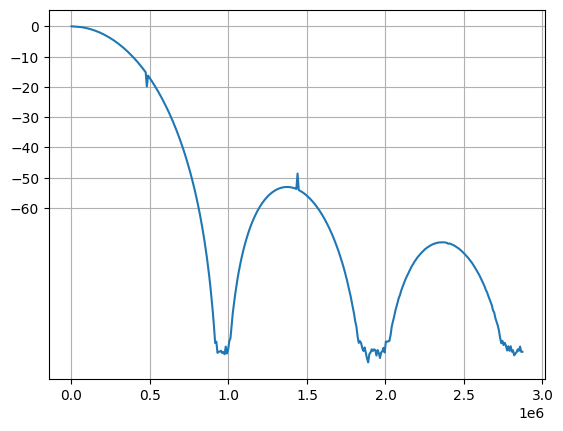

In [6]:
plt.grid()
plt.yticks(np.arange(-60, 1, 10))
plt.plot(np.array(freqs_to_scan)[np.where((freqs_to_scan < 3*9.6e5) & (freqs_to_scan > 0))], np.array(attenuation_dbs)[np.where((freqs_to_scan < 3*9.6e5) & (freqs_to_scan > 0))])

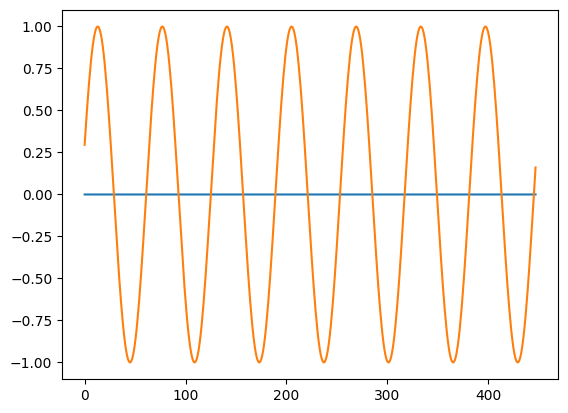

In [28]:
plt.plot(signal_filtered)

plt.plot(signal[:len(signal_filtered)])

In [13]:
filtered_peak = np.max(np.abs(fft(signal_filtered * flattop(len(signal_filtered)))) * (2.0/len(signal_filtered)))
raw_peak = np.max(np.abs(fft(signal * flattop(len(signal)))) * (2.0/len(signal)))
filtered_peak, raw_peak

(np.float64(0.3677237881599177), np.float64(0.36674233138891354))

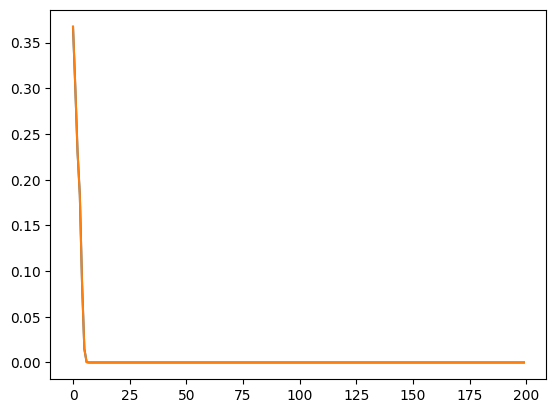

In [12]:
plt.plot(raw_fft[:200])
plt.plot(filtered_fft[:200])